# Final handin ML4ED 2023 - Calcularis

In this notebook, you will do a research investigation of your chosen dataset in teams. You will begin by formally selecting your research question (task 0), then processing your data (task 1), creating a predictive model (task 2), evaluating your model's results (task 3), and describing the contributions of each team member (task 4).

For grading, please make sure your notebook has all cells run and is stored in your team's [Github Classroom repository](https://classroom.github.com/a/CNxME27U). You will also need to write a short, 2 page report about your design decisions as a team, to be stored in your repository. The Milestone 4 submission will be the contents of your repository at the due date (April 28 at 23:59 CET).

## Brief overview of Calcularis
[Calcularis](https://school.alemira.com/de/calcularis/) by Alemira School is a mathematics learning program developed with neuroscientists and computer scientists from ETH Zurich. It promotes the development and interaction of the different areas of the brain that are responsible for processing numbers and quantities and solving mathematical tasks. Calcularis can be used from 1st grade to high school. Children with dyscalculia also benefit in the long term and overcome their arithmetic weakness.

The Calcularis dataset has three main tables:
* ***users***: meta information about users (i.e. total time spent learning with Calcularis, geographic location).
* ***events***: events done by the users in the platform (i.e. playing a game, selecting a new animal in the zoo simulation).
* ***subtasks***: sub-tasks with answer attempts solved by users, primarily in the context of game events.

These tables and useful metadata information are described in detail in the [Milestone 2 data exploration notebook](https://github.com/epfl-ml4ed/mlbd-2023/blob/main/project/milestone-02/m2_calcularis_sciper.ipynb).

We have provided access to the [full dataset](https://moodle.epfl.ch/mod/forum/discuss.php?d=88179) (~65k users) and a randomly selected subset (~1k users from M2). We have also provided access to a [test account to experiment with Calcularis](https://moodle.epfl.ch/mod/forum/discuss.php?d=88094). You should provide arguments and justifications for all of your design decisions throughout this investigation. You can use your M3 responses as the basis for this discussion.

In [1]:
# Import the tables of the data set as dataframes.
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import euclidean, pdist, squareform
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.sparse.csgraph import laplacian
from scipy.spatial import distance
from sklearn.cluster import KMeans
from sklearn.neighbors import kneighbors_graph
from sklearn.manifold import spectral_embedding

from pyts.metrics import dtw, itakura_parallelogram, sakoe_chiba_band
from pyts.metrics.dtw import (cost_matrix, accumulated_cost_matrix,
                              _return_path, _blurred_path_region)
from tslearn.clustering import TimeSeriesKMeans, silhouette_score, KShape
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

WEEKS_A_YEAR = 52 
WEEKS = 15

%matplotlib inline

In [2]:
# Import the tables of the data set as dataframes.

DATA_DIR_full_dataset = './data/00_data_full' # You many change the directory
DATA_DIR_small_dataset = './data/00_data_1000_students'

# You can use the nrows=X argument in pd.read_csv to truncate your data
#users = pd.read_csv('{}/calcularis_small_users.csv'.format(DATA_DIR_small_dataset), index_col=0)
#events = pd.read_csv('{}/calcularis_small_events.csv'.format(DATA_DIR_small_dataset), index_col=0)
#subtasks = pd.read_csv('{}/calcularis_small_subtasks.csv'.format(DATA_DIR_small_dataset), index_col=0)
users = pd.read_csv('{}/full_calcularis_users.csv'.format(DATA_DIR_full_dataset), index_col=0)
events = pd.read_csv('{}/full_calcularis_events.csv'.format(DATA_DIR_full_dataset), index_col=0)
subtasks = pd.read_csv('{}/full_calcularis_subtasks.csv'.format(DATA_DIR_full_dataset), index_col=0)

print(f'Number of users: {len(users)}')
print(f'Number of events: {len(events)}')
print(f'Number of subtasks: {len(subtasks)}')

Number of users: 64932
Number of events: 2185200
Number of subtasks: 3502884


## Task 0: Research Question

**Research question:**
*Time series clustering per student to look at the difference between guided training and free training, with the goal of learning what type of learner each  student is.*

## Task 1: Data Preprocessing

In this section, you are asked to preprocess your data in a way that is relevant for the model. Please include 1-2 visualizations of features / data explorations that are related to your downstream prediction task.

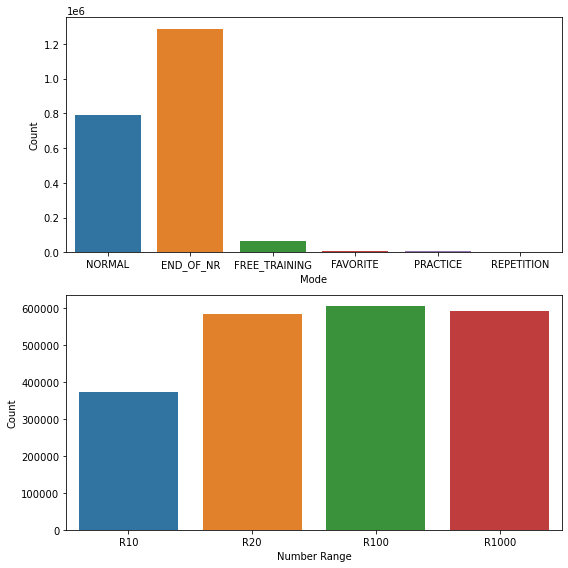

In [3]:
fig, axs = plt.subplots(2,1, figsize=(8, 8))
sns.countplot(data = pd.DataFrame(events['mode']), x = 'mode', ax = axs[0])
# Make axis labels nicer
axs[0].set_xlabel("Mode")
axs[0].set_ylabel("Count")
sns.countplot(data = pd.DataFrame(events['number_range']), x = 'number_range', ax = axs[1])
# Make axis labels nicer
axs[1].set_xlabel("Number Range")
axs[1].set_ylabel("Count")
plt.tight_layout()
plt.show()

In [4]:
# Sort the dataframes per training mode: guided training (gt) and free training (ft)

events_gt = events[events['mode'].isin(['NORMAL', 'END_OF_NR', 'FAVORITE', 'REPETITION'])]
events_ft = events[events['mode'].isin(['FREE_TRAINING'])]
subtasks_gt = subtasks[subtasks['event_id'].isin(events_gt.index)]
subtasks_ft = subtasks[subtasks['event_id'].isin(events_ft.index)]
print(f'Length of GUIDED training events dataframe: {len(events_gt)}\nLength of GUIDED training subtasks dataframe: {len(subtasks_gt)}')
print(f'Length of FREE training events dataframe: {len(events_ft)}\nLength of FREE training subtasks dataframe: {len(subtasks_ft)}')
print(f'Users in guided: {len(events_gt["user_id"].unique())} and in free training: {len(events_ft["user_id"].unique())}')

Length of GUIDED training events dataframe: 2085189
Length of GUIDED training subtasks dataframe: 3358682
Length of FREE training events dataframe: 63447
Length of FREE training subtasks dataframe: 133400
Users in guided: 59817 and in free training: 8137


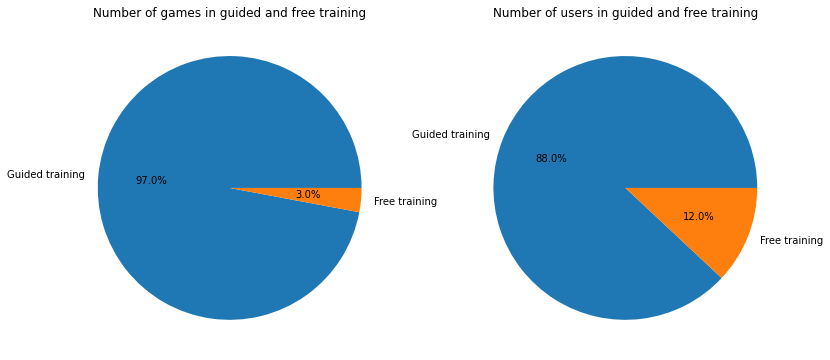

In [5]:
# pie for number of games in FT vs GT
data_1 = [len(events_gt), len(events_ft)]

# pie for number of users in FT vs GT
num_users_gt = len(events_gt["user_id"].unique())
num_users_ft = len(events_ft["user_id"].unique())
data_2 = [num_users_gt, num_users_ft]

# plot the pie charts
labels = ["Guided training", "Free training"]
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (13,9))
ax1.pie(data_1, labels=labels, autopct='%1.1f%%')
ax1.set_title("Number of games in guided and free training")
ax2.pie(data_2, labels=labels, autopct='%1.1f%%')
ax2.set_title("Number of users in guided and free training")
plt.show()

In [6]:
# Functions that work on the effort dataframe
def create_events_subtasks(mode):
    if (mode == 'guided'):
        df_events = events_gt
        df_subtasks = subtasks_gt
    elif (mode == 'free'):
        df_events = events_ft
        df_subtasks = subtasks_ft
    else:
        raise ValueError("Incorrect mode selected: either guided or free")
    return df_events, df_subtasks

def create_smaller_dataset(events, subtasks, nb_of_considered_users):
    #random sample on users
    different_users = np.array(events['user_id'].unique())
    users_rng = np.random.choice(different_users, nb_of_considered_users, replace = False)
    events_small = events.loc[events['user_id'].isin(users_rng)]
    subtasks_small = subtasks.loc[subtasks['user_id'].isin(users_rng)]
    return events_small, subtasks_small

def add_week_dimension(df_events, df_subtasks):
    events_copy = df_events.copy()
    subtasks_copy = df_subtasks.copy()
    
    years = pd.to_datetime(events_copy['start'], infer_datetime_format=True).dt.isocalendar().year
    first_year = years.min()
    events_copy["week"] = pd.to_datetime(events_copy['start'], infer_datetime_format=True).dt.isocalendar().year-first_year
    events_copy["week"] = events_copy["week"]*WEEKS_A_YEAR +pd.to_datetime(events_copy['start'], infer_datetime_format=True).dt.isocalendar().week
    start_weeks = pd.Series(events_copy.groupby(by="user_id").min()["week"], name="start_weeks")
    subtasks_copy["week"] = pd.to_datetime(subtasks_copy['subtask_finished_timestamp'], infer_datetime_format=True).dt.isocalendar().year-first_year
    subtasks_copy["week"] = subtasks_copy["week"]*WEEKS_A_YEAR+pd.to_datetime(subtasks_copy['subtask_finished_timestamp'], infer_datetime_format=True).dt.isocalendar().week
    # Now actually change it to each user starting with week 0
    for user, start in start_weeks.items():
        events_copy.loc[events_copy["user_id"] == user, "week"] = events_copy[events_copy["user_id"] == user]["week"]-start
        subtasks_copy.loc[subtasks_copy["user_id"] == user, "week"] = subtasks_copy[subtasks_copy["user_id"] == user]["week"]-start
    return events_copy, subtasks_copy

In [7]:
# Effort features
def effort_features(df_events, df_subtasks):
  # Total time learning per week
  time_online = df_events.groupby(by=["user_id", "week"]).sum()["learning_time_ms"]
  #print(time_online.head())
  # TODO maybe total time online per week?

  # Total interactions per week, here interactions we define as events and weeks
  events_done = pd.Series(df_events.groupby(by=["user_id", "week"]).count()["skill_id"], name="events_done")
  #sns.histplot(events_done)
  #plt.show()

  subtasks_done = pd.Series(df_subtasks.groupby(by=["user_id", "week"]).count()["event_id"], name="subtasks_done")
  #sns.histplot(subtasks_done)
  #plt.show()
  
  # features Maxime
  df_events['difficulty'] = df_events['number_range'].replace({'R10': 1, 'R20': 2, 'R100': 3, 'R1000': 4})
  features = pd.DataFrame()
  features['Nb_of_different games'] = df_events.groupby(['user_id', 'week'])['game_name'].unique().apply(lambda example : len(example))
  features['correct'] = df_subtasks.groupby(['user_id','week'])['correct'].apply(lambda example: sum(example)/len(example))
  features['avg_difficulty'] = df_events.groupby(['user_id','week'])['difficulty'].mean()

  effort = pd.DataFrame({
    "time_online": time_online,  
    "events_done": events_done,  
    "subtasks_done": subtasks_done,
    "Nb_of_different_games": features['Nb_of_different games'],  
    "correct": features['correct'],
    #  "avg_difficulty": features['avg_difficulty']   # Vivi's feature contains this
    })
  return effort

In [8]:
# Assessment feature
def assessment_features(df_events, df_subtasks):
    # Parse ranges in two different ways. TODO: choose which one makes more sense
    df_events['range_linear']  = df_events['number_range'].replace({'R10': 1, 'R20': 2, 'R100': 3, 'R1000': 4})
    df_events['range_default'] = df_events['number_range'].replace({'R10': 10, 'R20': 20, 'R100': 100, 'R1000': 1000})

    # assessment['num_attempts'] = subtasks.groupby(['user_id','week'])['event_id'].count()
    # assessment = assessment.merge(events['user_id', 'week', 'range_linear', 'range_default'], on= ['user_id', 'week'], how='left')

    # Number of attempts per user and week on every event
    subtasks_count = df_subtasks.groupby(['user_id','week', 'event_id']).size().reset_index().rename(columns={0: 'user_num_attempts'})
    user_assessment = df_events.merge(subtasks_count, on=['user_id','week', 'event_id'])[['event_id','user_id', 'week', 'range_linear', 'range_default', 'user_num_attempts']]

    # Number of unique users per subtask
    # TODO: check whether num_users_per_subtask is correct bc weird results with small dataset
    # Checking by 
    # user_assessment.groupby('user_id')['event_id'].count().rename('events_count').reset_index()
    # subtasks[subtasks['event_id'] == 0]
    num_users_per_subtask = df_subtasks.groupby('event_id')['user_id'].nunique()
    num_users_per_subtask.reset_index()
    # Events played by user
    # events_per_user = user_assessment.groupby('user_id')['event_id'].count().rename('idk_count').reset_index()

    # Can we know users played by users? find unique event_id by user_id in subtasks?
    # subtasks.groupby(['event_id', 'user_id']).count().reset_index().merge(subtasks, on= ['event_id', 'user_id'], how= 'left')

    # Average assessment feature (for all users)
    num_users_tried = df_subtasks.groupby('event_id')['user_id'].nunique().rename('num_users_tried').reset_index() # TODO: check its correct
    # avg_assessment_lin
    # Linear range
    min_range_lin = user_assessment.groupby('event_id')['range_linear'].min().rename('min_range_lin').reset_index()
    avg_range_lin = user_assessment.groupby('event_id')['range_linear'].mean().rename('avg_range_lin').reset_index()
    max_range_lin = user_assessment.groupby('event_id')['range_linear'].max().rename('max_range_lin').reset_index()

    ev_copy = df_events[['range_linear', 'range_default']]
    avg_assessment_lin = ev_copy.merge(min_range_lin, on='event_id')
    avg_assessment_lin = avg_assessment_lin.merge(avg_range_lin, on='event_id')
    avg_assessment_lin = avg_assessment_lin.merge(max_range_lin, on='event_id')
    avg_assessment_lin = avg_assessment_lin.merge(num_users_tried, on='event_id')

    avg_assessment_lin = avg_assessment_lin[['event_id', 'min_range_lin', 'avg_range_lin', 'max_range_lin', 'range_linear', 'num_users_tried']]


    # Default range
    min_range_def = user_assessment.groupby('event_id')['range_default'].min().rename('min_range_def').reset_index()
    avg_range_def = user_assessment.groupby('event_id')['range_default'].mean().rename('avg_range_def').reset_index()
    max_range_def = user_assessment.groupby('event_id')['range_default'].max().rename('max_range_def').reset_index()

    avg_assessment_def = ev_copy.merge(min_range_def, on='event_id')
    avg_assessment_def = avg_assessment_def.merge(avg_range_def, on='event_id')
    avg_assessment_def = avg_assessment_def.merge(max_range_def, on='event_id')
    avg_assessment_def = avg_assessment_def.merge(num_users_tried, on='event_id')

    avg_assessment_def = avg_assessment_def[['event_id', 'min_range_def', 'avg_range_def', 'max_range_def', 'range_default', 'num_users_tried']]

    # Average assessment feature (for all users)
    num_users_tried = df_subtasks.groupby('event_id')['user_id'].nunique().rename('num_users_tried').reset_index() # TODO: check its correct
    # avg_assessment_lin
    # Linear range
    min_range_lin = user_assessment.groupby('event_id')['range_linear'].min().rename('min_range_lin').reset_index()
    avg_range_lin = user_assessment.groupby('event_id')['range_linear'].mean().rename('avg_range_lin').reset_index()
    max_range_lin = user_assessment.groupby('event_id')['range_linear'].max().rename('max_range_lin').reset_index()

    ev_copy = df_events[['range_linear', 'range_default']]
    avg_assessment_lin = ev_copy.merge(min_range_lin, on='event_id')
    avg_assessment_lin = avg_assessment_lin.merge(avg_range_lin, on='event_id')
    avg_assessment_lin = avg_assessment_lin.merge(max_range_lin, on='event_id')
    avg_assessment_lin = avg_assessment_lin.merge(num_users_tried, on='event_id')

    avg_assessment_lin = avg_assessment_lin[['event_id', 'min_range_lin', 'avg_range_lin', 'max_range_lin', 'range_linear', 'num_users_tried']]


    # Default range
    min_range_def = user_assessment.groupby('event_id')['range_default'].min().rename('min_range_def').reset_index()
    avg_range_def = user_assessment.groupby('event_id')['range_default'].mean().rename('avg_range_def').reset_index()
    max_range_def = user_assessment.groupby('event_id')['range_default'].max().rename('max_range_def').reset_index()

    avg_assessment_def = ev_copy.merge(min_range_def, on='event_id')
    avg_assessment_def = avg_assessment_def.merge(avg_range_def, on='event_id')
    avg_assessment_def = avg_assessment_def.merge(max_range_def, on='event_id')
    avg_assessment_def = avg_assessment_def.merge(num_users_tried, on='event_id')

    avg_assessment_def = avg_assessment_def[['event_id', 'min_range_def', 'avg_range_def', 'max_range_def', 'range_default', 'num_users_tried']]

    # Left join between users_assessment and average_assessment
    user_assessment = user_assessment.merge(avg_assessment_lin, how='left')

    # Attempts_diff gives you a intuition on how is the user doing in comparison with other users
    user_assessment['attempts_diff_lin'] = user_assessment['user_num_attempts'] - user_assessment['avg_range_lin']

    user_assessment = user_assessment.merge(avg_assessment_def, how='left')

    # Attempts_diff gives you a intuition on how is the user doing in comparison with other users
    user_assessment['attempts_diff_def'] = user_assessment['user_num_attempts'] - user_assessment['avg_range_def']
    range_linear = user_assessment.groupby(['user_id', 'week']).count()['range_linear']
    # range_linear.tail(20)

    # Assessment pipeline for linear and default difficulty range

    user_num_attempts = user_assessment.groupby(['user_id', 'week'])['user_num_attempts'].mean()
    num_users_tried = user_assessment.groupby(['user_id', 'week'])['num_users_tried'].mean()

    range_linear = user_assessment.groupby(['user_id', 'week'])['range_linear'].mean()
    attempts_diff_lin = user_assessment.groupby(['user_id', 'week'])['attempts_diff_lin'].mean()
    min_range_lin = user_assessment.groupby(['user_id', 'week'])['min_range_lin'].mean()
    avg_range_lin = user_assessment.groupby(['user_id', 'week'])['avg_range_lin'].mean()
    max_range_lin = user_assessment.groupby(['user_id', 'week'])['max_range_lin'].mean()

    assessment_lin = pd.DataFrame({
        "range_linear":  range_linear,
        "user_num_attempts": user_num_attempts,
        "num_users_tried": num_users_tried,
        "attempts_diff": attempts_diff_lin,
        "min_range_lin": min_range_lin,
        "avg_range_lin": avg_range_lin,
        "max_range_lin": max_range_lin,
    })

    range_default = user_assessment.groupby(['user_id', 'week'])['range_default'].mean()
    attempts_diff_def = user_assessment.groupby(['user_id', 'week'])['attempts_diff_lin'].mean()
    min_range_def = user_assessment.groupby(['user_id', 'week'])['min_range_def'].mean()
    avg_range_def = user_assessment.groupby(['user_id', 'week'])['avg_range_def'].mean()
    max_range_def = user_assessment.groupby(['user_id', 'week'])['max_range_def'].mean()

    assessment_def = pd.DataFrame({
        "range_linear":  range_linear,
        "user_num_attempts": user_num_attempts,
        "num_users_tried": num_users_tried,
        "attempts_diff": attempts_diff_def,
        "min_range_def": min_range_def,
        "avg_range_def": avg_range_def,
        "max_range_def": max_range_def,
    })

    return assessment_lin, assessment_def

In [9]:
# Standardize the columns of a dataframe so that every column contributes the same amount in the clustering
def standardize_columns(df):
    for col in df.columns:
        df[col] = TimeSeriesScalerMeanVariance().fit_transform([df[col]])[0]
    return df

In [10]:
# Preprocessing pipeline
training_mode = 'guided'
df_events, df_subtasks = create_events_subtasks(training_mode)
df_events, df_subtasks = create_smaller_dataset(df_events, df_subtasks, nb_of_considered_users = 8000)#8137) #59817) #there might not be enough users for free training if number too big
df_events, df_subtasks = add_week_dimension(df_events, df_subtasks)

In [11]:
effort = effort_features(df_events, df_subtasks)
effort = standardize_columns(effort)
effort.head()

time_online  events_done  subtasks_done  Nb_of_different_games  \
user_id week                                                                   
2       0       -0.098529    -0.169647      -0.165787               0.140289   
        1       -0.170300     0.946051       0.301575               1.025255   
        2       -0.212491     0.388202      -0.165787               1.025255   
        3       -0.196107     0.388202      -0.165787              -0.744677   
        4        0.580647     1.503900       0.301575               1.025255   

               correct  
user_id week            
2       0    -0.221979  
        1     0.740727  
        2     0.740727  
        3    -0.221979  
        4    -0.992144

In [12]:
assessment_lin, assessment_def = assessment_features(df_events, df_subtasks)
assessment_lin = standardize_columns(assessment_lin)
assessment_lin.head()

range_linear  user_num_attempts  num_users_tried  attempts_diff  \
user_id week                                                                    
2       0        -1.597638          -0.061368              0.0       0.838595   
        1        -1.113993          -0.213541              0.0       0.433045   
        2        -0.630348          -0.365715              0.0       0.027494   
        3         0.336942          -0.365715              0.0      -0.513241   
        4         0.336942          -0.365715              0.0      -0.513241   

              min_range_lin  avg_range_lin  max_range_lin  
user_id week                                               
2       0         -1.597638      -1.597638      -1.597638  
        1         -1.113993      -1.113993      -1.113993  
        2         -0.630348      -0.630348      -0.630348  
        3          0.336942       0.336942       0.336942  
        4          0.336942       0.336942       0.336942

In [13]:
print(f"Users in df_events: {len(df_events['user_id'].unique())}")
print(f"Users in df_subtasks: {len(df_subtasks['user_id'].unique())}")
print(f"Count of users in effort: {len(effort.index.get_level_values('user_id').unique())}")
print(f"Count of users in assessment: {len(assessment_lin.index.get_level_values('user_id').unique())}")

Users in df_events: 8000
Users in df_subtasks: 8000
Count of users in effort: 8000
Count of users in assessment: 6971


*Your discussion about your processing decisions goes here*

Given the response by the StartUp that all "[...] modes (NORMAL, END_OF_NR, REPETITION, FAVORITE) are all part of guided training", we decided to make a split exactly along those game modes (on one side the all students that do guided traning and on the other side all students doing free training).
Further, as we want to do time-series clustering, we create each of the features possible from the "Identifying and comparing multi-dimensional student profiles across flipped classroom" paper per week (necessating the addition of week per event, describing the n'th week this student did a particular event, starting from 0 for each student when they logged in for the first time.)
Applying the assessment feature to our dataset was much more difficult than initially thought, but we ended up taking all basic skills as the same difficulty (e.g. addition, division) and pulling in on which number line this basic skill was tried.

The subsampling of our dataset was necessary because of the incredibly slow runtimes for the tslearn TimeSeriesKMeans (and initially also the spectral clustering).

## Task 2: Model Building

Train a model for your research question. 

In [14]:
# Your code for training a model goes here

# Combine all features and for now use the complete first 15 weeks (later also with 15 active weeks)
combined_features = effort[effort.index.get_level_values(1) <= WEEKS]
combined_features['attempts_diff'] = assessment_lin[assessment_lin.index.get_level_values(1) <= WEEKS]['attempts_diff']
combined_features['avg_range_lin'] = assessment_lin[assessment_lin.index.get_level_values(1) <= WEEKS]['avg_range_lin']

print(f"Shape: {combined_features.shape}")
combined_features.describe()

Shape: (55508, 7)


/tmp/ipykernel_10830/701829638.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_features['attempts_diff'] = assessment_lin[assessment_lin.index.get_level_values(1) <= WEEKS]['attempts_diff']
/tmp/ipykernel_10830/701829638.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_features['avg_range_lin'] = assessment_lin[assessment_lin.index.get_level_values(1) <= WEEKS]['avg_range_lin']


,time_online,events_done,subtasks_done,Nb_of_different_games,correct,attempts_diff,avg_range_lin
count,55508.000000,55508.000000,44051.000000,55508.000000,44051.000000,44051.000000,44051.000000
mean,0.012026,0.152432,0.052192,0.110491,-0.064951,0.232399,-0.502767
std,1.234140,1.134397,0.958423,1.077929,0.979750,0.787591,0.945064
min,-0.405738,-0.727496,-0.633150,-0.744677,-2.147392,-1.053975,-1.597638
25%,-0.317562,-0.727496,-0.399469,-0.744677,-0.703332,-0.332996,-1.597638
50%,-0.199651,-0.169647,-0.165787,0.140289,0.328139,0.162677,-0.630348
75%,0.073085,0.388202,0.301575,1.025255,0.740727,0.568228,0.336942
max,237.638312,26.049250,22.033921,10.759881,0.740727,12.058836,1.304232


### Outliers detection to the combined features

In [15]:
def create_mean_features(combined_features):
    df_mean_features = pd.DataFrame()
    for col in combined_features.columns:
        df_mean_features['mean_' + col] = combined_features.groupby(['user_id'])[col].mean()
    df_mean_features = df_mean_features.fillna(0)
    return df_mean_features

def outliers_detection(combined_features, std_threshold, feature):
    df_mean_features = create_mean_features(combined_features)
    
    val = df_mean_features[feature].values
    mask = np.abs(val - np.mean(val)) <= std_threshold*np.std(val)
    df_mean_features_OD = df_mean_features[mask]
    outliers_idx = np.where(mask == 0)
    outliers_user_id = np.array(df_mean_features.iloc[outliers_idx].index)
    idx_user = np.array(combined_features.index.get_level_values(0).unique())
    idx_user_sorted = idx_user[~np.isin(idx_user, outliers_user_id)]
    combined_features_OD = combined_features[combined_features.index.get_level_values(0).isin(idx_user_sorted)]
    return combined_features_OD, df_mean_features_OD

In [16]:
# outliers detection on all features
combined_features_OD, df_mean_features_OD = outliers_detection(combined_features, 3, 'mean_time_online')
#combined_features_OD, df_mean_features_OD = outliers_detection(combined_features_OD, 3, 'mean_events_done')
#combined_features_OD, df_mean_features_OD = outliers_detection(combined_features_OD, 3, 'mean_subtasks_done')
#combined_features_OD, df_mean_features_OD = outliers_detection(combined_features_OD, 3, 'mean_Nb_of_different_games')
#combined_features_OD, df_mean_features_OD = outliers_detection(combined_features_OD, 3, 'mean_correct')
#combined_features_OD, df_mean_features_OD = outliers_detection(combined_features_OD, 3, 'mean_attempts_diff')
#combined_features_OD, df_mean_features_OD = outliers_detection(combined_features_OD, 3, 'mean_avg_range_lin')

print(f'Number of users with outliers: {len(combined_features.index.get_level_values(0).unique())}')
print(f'Number of users without outliers : {len(combined_features_OD.index.get_level_values(0).unique())}')

Number of users with outliers: 8000
Number of users without outliers : 7980


Text(0.5, 1.0, 'Mean features for 7980 users after outliers detection')

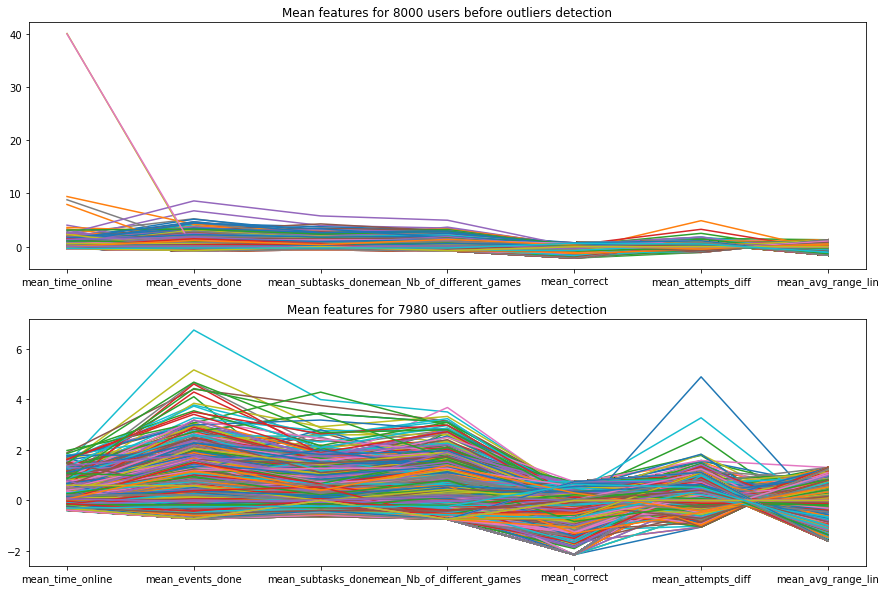

In [17]:
#Visualization
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15,10))
df_mean_features = create_mean_features(combined_features)
ax1.plot(df_mean_features.columns, np.array(df_mean_features.values).T)
ax1.set_title(f'Mean features for {len(combined_features.index.get_level_values(0).unique())} users before outliers detection')
ax2.plot(df_mean_features_OD.columns, np.array(df_mean_features_OD.values).T)
ax2.set_title(f'Mean features for {len(combined_features_OD.index.get_level_values(0).unique())} users after outliers detection')

In [18]:
combined_features.describe()

,time_online,events_done,subtasks_done,Nb_of_different_games,correct,attempts_diff,avg_range_lin
count,55508.000000,55508.000000,44051.000000,55508.000000,44051.000000,44051.000000,44051.000000
mean,0.012026,0.152432,0.052192,0.110491,-0.064951,0.232399,-0.502767
std,1.234140,1.134397,0.958423,1.077929,0.979750,0.787591,0.945064
min,-0.405738,-0.727496,-0.633150,-0.744677,-2.147392,-1.053975,-1.597638
25%,-0.317562,-0.727496,-0.399469,-0.744677,-0.703332,-0.332996,-1.597638
50%,-0.199651,-0.169647,-0.165787,0.140289,0.328139,0.162677,-0.630348
75%,0.073085,0.388202,0.301575,1.025255,0.740727,0.568228,0.336942
max,237.638312,26.049250,22.033921,10.759881,0.740727,12.058836,1.304232


In [19]:
combined_features_OD.describe()

,time_online,events_done,subtasks_done,Nb_of_different_games,correct,attempts_diff,avg_range_lin
count,55380.000000,55380.000000,43982.000000,55380.000000,43982.000000,43982.000000,43982.000000
mean,-0.001223,0.146659,0.047390,0.107067,-0.065074,0.232608,-0.503109
std,0.571993,1.108427,0.938760,1.070033,0.980323,0.787725,0.944756
min,-0.405738,-0.727496,-0.633150,-0.744677,-2.147392,-1.053975,-1.597638
25%,-0.317637,-0.727496,-0.399469,-0.744677,-0.703332,-0.332996,-1.597638
50%,-0.200030,-0.169647,-0.165787,0.140289,0.328139,0.162677,-0.630348
75%,0.070991,0.388202,0.301575,1.025255,0.740727,0.568228,0.336942
max,13.731002,19.355063,22.033921,8.104983,0.740727,12.058836,1.304232


Simpler direct application of tslearn k-means to the raw set of our features.

In [20]:
def create_reshaped_feature(combined_features):
    reshaped_feature = pd.DataFrame(combined_features, copy=True).fillna(0)
    print(f"Each element will be a list of {reshaped_feature.columns.values} features")
    # Create a combined feater list and unstack it
    reshaped_feature["combined"] = reshaped_feature.values.tolist()
    reshaped_feature = reshaped_feature["combined"].unstack(level=1)
    # Sort columns by week, as now it is a time series
    reshaped_feature = reshaped_feature.reindex(sorted(reshaped_feature.columns), axis=1)
    reshaped_feature.head()
    return reshaped_feature

#apply outliers detection
combined_features = combined_features_OD
reshaped_feature = create_reshaped_feature(combined_features)
reshaped_feature.head()

Each element will be a list of ['time_online' 'events_done' 'subtasks_done' 'Nb_of_different_games'
 'correct' 'attempts_diff' 'avg_range_lin'] features


week,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
user_id,,,,,,,,,,,,,,,,
2,"[-0.09852888305024249, -0.16964695209698277, -...","[-0.17029991601670974, 0.9460507863412262, 0.3...","[-0.21249058117061997, 0.38820191712212165, -0...","[-0.19610678825966493, 0.38820191712212165, -0...","[0.5806470215180721, 1.5038996555603306, 0.301...","[0.6611269411522364, 2.061748524779435, 0.5352...","[0.12522661271674318, 0.9460507863412262, 0.06...","[-0.08295521913163136, 1.5038996555603306, 0.5...",NaN,"[-0.29697850739848564, 0.38820191712212165, 0....","[-0.023250844314286468, 0.38820191712212165, 0...","[0.893815175019014, 2.061748524779435, 2.63838...","[2.2250916204641493, 3.7352951324367485, 3.806...","[0.5414517017174334, 1.5038996555603306, 0.301...","[0.16062711776377092, 1.5038996555603306, 0.76...","[0.23137482989780378, 0.38820191712212165, -0...."
6,"[-0.2913395832280919, -0.7274958213160873, -0....",NaN,NaN,"[-0.35890007735277174, -0.7274958213160873, -0...","[-0.08663277837319251, 1.5038996555603306, 0.7...","[0.08146898753816778, 0.9460507863412262, 0.30...","[-0.2851143814974492, -0.16964695209698277, -0...","[0.3500693868681904, 0.9460507863412262, 1.937...","[3.7811788612847184, 1.5038996555603306, 10.11...","[1.3744668380950538, 0.9460507863412262, 4.975...","[-0.09493660054471753, -0.16964695209698277, -...",NaN,NaN,NaN,"[1.9104417836745784, 0.38820191712212165, 5.44...",NaN
33,"[0.16434731537335018, 0.38820191712212165, 0.0...",NaN,NaN,"[-0.3331038647018211, -0.7274958213160873, -0....","[-0.333082545517812, -0.7274958213160873, -0.6...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.20300354428659265, 0.38820191712212165, -0...","[-0.2594354243585483, -0.16964695209698277, -0...","[0.5913066135225972, -0.7274958213160873, -0.6...","[-0.34618318409137333, -0.7274958213160873, -0..."
37,"[-0.3821593071066454, -0.7274958213160873, -0....",NaN,NaN,NaN,NaN,"[-0.4020074674190711, -0.7274958213160873, -0....","[-0.36980483997340086, -0.7274958213160873, -0...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,"[-0.31067608312430034, -0.7274958213160873, -0...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# Fill missing values with NaN filler list --> impossible to do in a smarter way
def fill_nans(reshaped_feature, combined_features):
    nan_filler_list = np.array([0] * len(combined_features.columns))
    arr = reshaped_feature.values
    nan_mask = np.vectorize(lambda x: isinstance(x, float) and np.isnan(x))(arr)
    for i in range(len(arr)):
        for j in range(len(arr[i])):
            if nan_mask[i][j]:
                arr[i][j] = nan_filler_list
            else:
                arr[i][j] = np.array(arr[i][j])

    arr = np.array([np.stack(x) for x in arr])
    return arr

arr = fill_nans(reshaped_feature, combined_features)

In [22]:
def stratified_sample(data, y_pred, n_samples, min_sample=15, verbose=False):
    df = pd.DataFrame(zip(y_pred, range(len(y_pred))), columns=['y_pred', 'idx'])
    n = min(n_samples, df.groupby('y_pred').count()['idx'].min())
    if n <= min_sample:
        counts = df.groupby('y_pred').count()
        if verbose:
            print(f"Doing sampling with less than {min_sample} in a class is not useful! Dropping all y_pred rows below {min_sample}")
        for y, cnt in counts.iterrows():
            if cnt[0] <= min_sample:
                df[df['y_pred'] == y] = np.nan
        n = min(n_samples, df.groupby('y_pred').count()['idx'].min())
        assert n > min_sample
    if verbose:
        print(f"Trying to sample size {n}")
    counts = []
    un = np.unique(np.array(y_pred), return_counts=True)
    index_counter = 0
    for idx, val in zip(un[0], un[1]):
        if idx == index_counter:
            index_counter += 1
            counts.append(val)
        else:
            index_counter += 2
            counts.append(0)
            counts.append(val)
    counts = [int(x) if x > 0 else 1 for x in counts / np.sum(counts) * n]
    df_ = df.groupby('y_pred').apply(lambda x: x.sample(counts[int(x['y_pred'].iloc[0])]))
    df_.index = df_.index.droplevel(0)
    sampled_y_pred = y_pred[df_.index] 
    sampled_data = data[df_.index]
    if verbose:
        print(f"Actual sample size {len(sampled_y_pred)}")
    return sampled_data, sampled_y_pred

def smart_silhouette_score(data, y_pred, y_classes=5, subsample_size=200, N=25):
    np.random.seed(1337)
    ss_l = []
    for i in range(N):
        # Same sample the data stratified
        sub_sample_arr, sub_sample_ypred = stratified_sample(data, y_pred, subsample_size)
        s_ss = silhouette_score(sub_sample_arr, sub_sample_ypred, n_jobs=-1)
        ss_l.append(s_ss)
        print(f"Got: {s_ss:.2f} SS {'.' * i}", end='\r', flush=True)
    return np.mean(ss_l), np.std(ss_l)

#smart_silhouette_score(arr, y_pred)

In [23]:
# Multivariate time series clustering using normal DTW
def find_k():
    print("DBA k-means for multivariate clustering")
    silhouette_list = []
    silhouette_list_std = []
    distortion_list = []
    rang = range(2, 10)
    for clusters in rang:
        print(f"Doing now with {clusters} clusters.")
        dba_km = TimeSeriesKMeans(n_clusters=clusters,
                              #n_init=2,
                              metric="dtw",
                              verbose=False,
                              n_jobs=-1,
                              max_iter_barycenter=50,
                              random_state=69)
        y_pred = dba_km.fit_predict(arr)
        distortion = dba_km.inertia_
        distortion_list.append(distortion)
        ss, ss_std = smart_silhouette_score(arr, y_pred)
        silhouette_list.append(ss)
        silhouette_list_std.append(ss_std)

    sns.lineplot(x=rang, y=silhouette_list)
    sns.lineplot(x=rang, y=distortion_list)
    plt.show()
#ss, ss_std = find_k()

Now lets try a different approach with k-Shape instead of KMeans.

In [ ]:
# Multivariate time series clustering using soft DTW
def find_k():
    print("softdtw k-means for multivariate clustering")
    silhouette_list = []
    silhouette_list_std = []
    distortion_list = []
    rang = range(2, 11)
    for clusters in rang:
        print(f"Doing now with {clusters} clusters.")
        dba_km = TimeSeriesKMeans(n_clusters=clusters,
                              #n_init=2,
                              metric="softdtw",
                              metric_params={"gamma": .5},
                              verbose=False,
                              n_jobs=-1,
                              max_iter_barycenter=50,
                              random_state=69)
        y_pred = dba_km.fit_predict(arr)
        distortion = dba_km.inertia_
        distortion_list.append(distortion)
        ss, ss_std = smart_silhouette_score(arr, y_pred)
        silhouette_list.append(ss)
        silhouette_list_std.append(ss_std)
    
    sns.lineplot(x=rang, y=silhouette_list)
    sns.lineplot(x=rang, y=distortion_list)
    plt.show()
    return silhouette_list, silhouette_list_std
#ss, ss_std = find_k()
#print(ss)
#print(ss_std)

In [25]:
# Multivariate time series clustering using KShapes
def find_k():
    print("K-Shape for multivariate clustering")
    silhouette_list = []
    silhouette_list_std = []
    distortion_list = []
    rang = range(2, 11)
    for clusters in rang:
        print(f"Doing now with {clusters} clusters.")
        kshape = KShape(n_clusters=clusters, n_init=3, random_state=1337)
        y_pred = kshape.fit_predict(arr)
        distortion = kshape.inertia_
        distortion_list.append(distortion)
        ss, ss_std = smart_silhouette_score(arr, y_pred)
        silhouette_list.append(ss)
        silhouette_list_std.append(ss_std)

    sns.lineplot(x=rang, y=silhouette_list)
    #sns.lineplot(x=rang, y=distortion_list)
    plt.show()
#ss, ss_std = find_k()

## Task 3: Model Evaluation
In this task, you will use metrics to evaluate your model.

In [26]:
K = 6

if training_mode == "guided":
    dba_km = TimeSeriesKMeans(n_clusters=K,
                          #n_init=2,
                          metric="softdtw",
                          metric_params={"gamma": .5},
                          verbose=True,
                          max_iter_barycenter=50,
                          n_jobs=-1,
                          random_state=69)
    y_pred = dba_km.fit_predict(arr)
    print("Done the fitting!")
else:
    y_pred = dba_km.predict(arr)
    print("Done predicting!")

1785.743 --> 1235.575 --> 1200.739 --> 1176.505 --> 1180.395 --> 1175.268 --> 1170.111 --> 1168.318 --> 1167.259 --> 1173.122 --> 1174.749 --> 1178.117 --> 1182.357 --> 1186.591 --> 1180.876 --> 1183.349 --> 1184.276 --> 1185.754 --> 1185.972 --> 1186.487 --> 1182.007 --> 1181.252 --> 1181.972 --> 1180.885 --> 1179.365 --> 1178.926 --> 1178.174 --> 1177.948 --> 1179.159 --> 1177.619 --> 1178.770 --> 1179.996 --> 1179.533 --> 1175.675 --> 1170.589 --> 1163.868 --> 1159.554 --> 1159.412 --> 1159.341 --> 1159.587 --> 1159.679 --> 1159.635 --> 1159.200 --> 1159.228 --> 1159.251 --> 1159.124 --> 1158.848 --> 1158.618 --> 1158.441 --> 1158.000 --> 
Done the fitting!


In [58]:
# Smart silhouette_score
if len(arr) < 200:
    ss = silhouette_score(arr, y_pred), 0
else:
    print("normal silhouette_score is super slow, calculating it using subsampling.")
    ss = smart_silhouette_score(arr, y_pred)
    print(f"Silhouette score achieved for the chosen cluster size of {K}: {ss[0]:.3f} with std of {ss[1]:.3f}")

normal silhouette_score is super slow, calculating it using subsampling.
Silhouette score achieved for the chosen cluster size of 6: 0.269 with std of 0.026


In [28]:
def save_clustering(name):
    # pickle both the model and the scaler as a single file
    with open(name, 'wb') as f:
        ids = combined_features.index.get_level_values(0).unique()
        pickle.dump((arr, y_pred, dba_km, combined_features, K, ss, ids), f)
#save_clustering('./dataSaves/clustering8kFreeFinal.pickle')

In [87]:
def load_clustering(name='clustering.pickle'):
    # First load the model and the scaler, return it as singletons
    with open(name, 'rb') as f:
        (arr, y_pred, dba_km, combined_features, K, ss, ids) = pickle.load(f)
        print(f"Loaded a save of {len(ids)} students!")
        return arr, y_pred, dba_km, combined_features, K, ss
arr, y_pred, dba_km, combined_features, K, ss = load_clustering('./dataSaves/clustering8kFinal.pickle')

Loaded a save of 8000 students!


##### Found clusters of students

In [88]:
print(f"Silhouette score achieved for the chosen cluster size of {K}: {ss[0]:.3f} with std of {ss[1]:.3f}")
counts = np.unique(y_pred, return_counts=True)
for clu, cnt in zip(counts[0], counts[1]):
    print(f"Cluster {clu} has {cnt:3} users")

Silhouette score achieved for the chosen cluster size of 6: 0.265 with std of 0.025
Cluster 0 has 5679 users
Cluster 1 has   1 users
Cluster 2 has   1 users
Cluster 3 has 663 users
Cluster 4 has 384 users
Cluster 5 has 1272 users


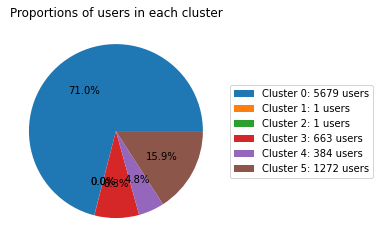

In [89]:
# calculate the counts of users per cluster
counts = np.unique(y_pred, return_counts=True)

# create a list of counts
count_list = [c for c in counts[1]]

# calculate the proportion of each cluster
proportions = [c / len(y_pred) for c in count_list]

# create custom labels for the pie chart
labels = [f'Cluster {clu}: {cnt} users' for clu, cnt in zip(counts[0], counts[1])]

# create a pie chart
plt.pie(proportions, autopct='%1.1f%%')

# create a legend for the custom labels
plt.legend(labels=labels, loc='center left', bbox_to_anchor=(1, 0.5))

plt.title("Proportions of users in each cluster", y=1.0)
plt.show()

In [61]:
# Calculate the error for each cluster per feature
print("Arr shape is:", arr.shape, ", len(y_pred):", len(y_pred), "and cluster center shape is:", dba_km.cluster_centers_.shape)

Arr shape is: (8000, 16, 7) , len(y_pred): 8000 and cluster center shape is: (6, 16, 7)


In [62]:
# Now lets look at these baricenters for those clusters per feature
def flatten(l):
    return [item for sublist in l for item in sublist]

def make_rgb_transparent(rgb, bg_rgb, alpha):
    return [alpha * c1 + (1 - alpha) * c2
            for (c1, c2) in zip(rgb, bg_rgb)]

In [63]:
#qualitative_colors = sns.color_palette("Set3", 10)
qualitative_colors = sns.color_palette("bright", 10)
def color_map(x):
    color = {
        1: qualitative_colors[1],
        2: qualitative_colors[2],
        3: qualitative_colors[3],
        4: qualitative_colors[4],
        5: qualitative_colors[5],
        6: qualitative_colors[6],
        7: qualitative_colors[7],
        8: qualitative_colors[8],
        9: qualitative_colors[0],
    }
    return color.get(x%10, qualitative_colors[0])

In [96]:
# Lets choose cluster to look at which don't have single digit number of students
clusters = [0, 3, 4, 5]

In [97]:
def baricenter_data_per_feature():
    for i in range(0, len(feature_names)):
        # Make a form out of the baricenters that seaborn can plot
        dt_frame = pd.DataFrame({
            f"Feature: {feature_names[i]}": flatten([dba_km.cluster_centers_[cluster, :, i].tolist() for cluster in clusters]),
            "Week": flatten([range(0, WEEKS+1) for _ in clusters]),
            "Cluster": flatten([[cluster]*(WEEKS+1) for cluster in clusters]),
        })
        
        yield dt_frame

In [98]:
def user_data_per_feature(sample_size=None):
    # X sample students with theirs assigned clusters
    if sample_size is not None:
        idx = np.random.choice(arr.shape[0], sample_size, replace=False)
        # Check class count for silhouette_score
        sub_sample_ypred = y_pred[idx]
        sub_sample_arr = arr[idx, :]
    else:
        # Full set, no subsampling
        sub_sample_ypred = y_pred
        sub_sample_arr = arr
    
    for i in range(0, len(feature_names)):
        dt_frame = pd.DataFrame({
            f"Feature: {feature_names[i]}": flatten(flatten(([sub_sample_arr[sub_sample_ypred[sub_sample_ypred == cluster], :, i].tolist() for cluster in clusters]))),
            "Week": flatten([range(0, WEEKS+1) for _ in sub_sample_arr]),
            "Cluster": flatten([[cluster]*(WEEKS+1) for cluster in sub_sample_ypred]),
        })
    
        yield dt_frame

In [99]:
# Print the shape of the baricenters
print(f"Baricenters shape: {dba_km.cluster_centers_.shape}")

# For each cluster we can at the full timeseries for each feature
feature_names = combined_features.columns.values 
print(f"All features: {feature_names}")

Baricenters shape: (6, 16, 7)
All features: ['time_online' 'events_done' 'subtasks_done' 'Nb_of_different_games'
 'correct' 'attempts_diff' 'avg_range_lin']


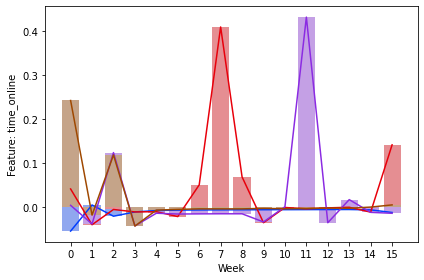

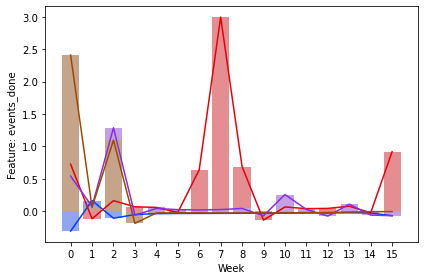

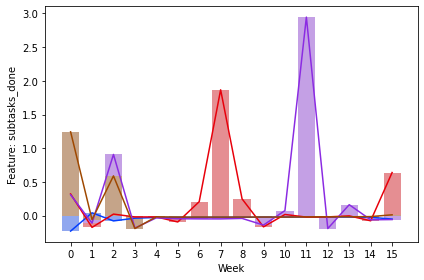

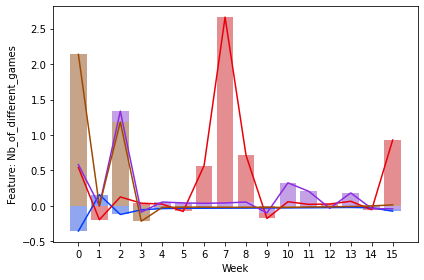

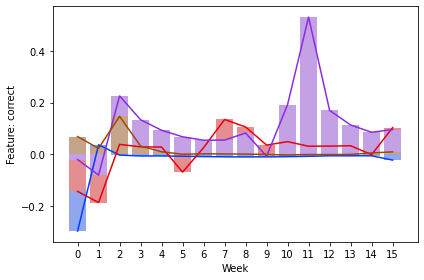

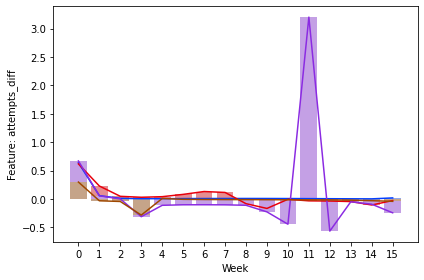

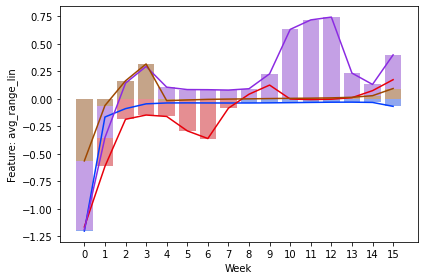

In [102]:
def barlineplot(dt_frame, clusters, feature_name, save=True):
    alpha = 0.5
    sns.color_palette('bright')
    ax = plt.subplots()
    for cluster in clusters:
        ax = sns.barplot(x=dt_frame[dt_frame["Cluster"] == cluster]["Week"], 
                         y=dt_frame[dt_frame["Cluster"] == cluster][feature_name],
                         color=make_rgb_transparent(color_map(cluster), (1,1,1), alpha), hue_order=dt_frame.sort_values("Cluster"))
    for cluster in clusters:
        ax = sns.lineplot(x=dt_frame[dt_frame["Cluster"] == cluster]["Week"], 
                         y=dt_frame[dt_frame["Cluster"] == cluster][feature_name],
                         color=color_map(cluster))
    #ax.legend(handles=ax.lines[-6:], labels=clusters, title="Cluster ID")
    plt.xlabel('Week')
    plt.tight_layout()
    if save:
        plt.savefig(f"figures/guided_baricenter_{feature_name}.png", dpi=300)
    plt.show()

# choose what data to look at
for feature_frame in baricenter_data_per_feature():
#for feature_frame in user_data_per_feature():
    #print(np.unique(feature_frame['Cluster'], return_counts=True))
    barlineplot(feature_frame, clusters, feature_frame.columns[0])

#### PCA

In [69]:
def create_reshaped_feature(combined_features):
    reshaped_feature = pd.DataFrame(combined_features, copy=True).fillna(0)
    print(f"Each element will be a list of {reshaped_feature.columns.values} features")
    # Create a combined feater list and unstack it
    reshaped_feature["combined"] = reshaped_feature.values.tolist()
    reshaped_feature = reshaped_feature["combined"].unstack(level=1)
    # Sort columns by week, as now it is a time series
    reshaped_feature = reshaped_feature.reindex(sorted(reshaped_feature.columns), axis=1)
    #reshaped_feature.head()
    return reshaped_feature

In [70]:
def user_data(sample_size=None):
    # X sample students with theirs assigned clusters
    if sample_size is not None:
        idx = np.random.choice(y_pred.shape[0], sample_size, replace=False)
    else:
        # Full set, no subsampling
        idx = range(y_pred.shape[0])
    
    clustered_data = combined_features.fillna(0)
    clustered_data['Cluster'] = -1
    reshaped_feature = create_reshaped_feature(combined_features)
    for i in idx:
        user_id = reshaped_feature.index[i]
        clustered_data.loc[clustered_data.index.get_level_values(0) == user_id, 'Cluster'] = y_pred[i]
    
    return clustered_data[clustered_data['Cluster'] != -1]

In [71]:
dt_frame = user_data(sample_size=5000)
dt_frame.shape

Each element will be a list of ['time_online' 'events_done' 'subtasks_done' 'Nb_of_different_games'
 'correct' 'attempts_diff' 'avg_range_lin'] features


(34411, 8)

In [72]:
np.unique(dt_frame['Cluster'], return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([19710,     6,    16,  4942,  2763,  6974]))

In [73]:
# Used in t-SNE
cluster_assignments = [f'Cluster {cls}' for cls in dt_frame['Cluster']]

In [74]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [75]:
# PCA 2D plotting
pca_2 = PCA(n_components=2)
df_pca = pca_2.fit_transform(dt_frame.iloc[:, :-1])
df_pca.shape

(34411, 2)

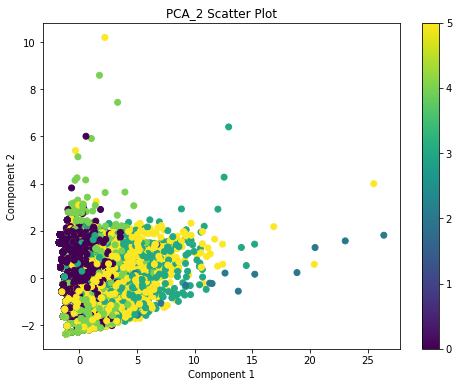

In [76]:
# Create a scatter plot of the first two PCA components
plt.figure(figsize=(8, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=dt_frame['Cluster'], cmap='viridis')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('PCA_2 Scatter Plot')
plt.colorbar()
plt.show()

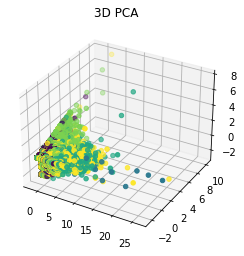

In [77]:
# PCA 3D plotting
# Note that PCA is not reducing its dimensionality because n_components = 3 and n_features of the dataframe = 3
# PCA will simply return the original 3 columns, but transformed into a new coordinate system that maximizes the variance of the data.
#%matplotlib widget
pca_3 = PCA(n_components=5)
df_pca_3 = pca_3.fit_transform(dt_frame.iloc[:, :-1])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(xs=df_pca_3[:, 0], ys=df_pca_3[:, 1], zs=df_pca_3[:, 2], c=dt_frame['Cluster'], cmap='viridis')

ax.set_title("3D PCA")
plt.show()

#### Elbow method to compare PCA with n_components = 2 or 3

In [78]:
# Eigen vectors prodeced by principal components can be checked this way
# PCs with low eigenvalues are likely to be noise, as they capture relatively little variance
# Make sure this changes after outlier detection
print("pca_2.components_:")
print(pca_2.components_ )
print("\npca_3.components_:")
print(pca_3.components_ )

pca_2.components_:
[[ 0.08963795  0.65646885  0.41840612  0.60492576  0.08645267 -0.0176318
   0.11058879]
 [ 0.02205332  0.06510203  0.1421992   0.0206974  -0.25630001  0.56985752
  -0.76432918]]

pca_3.components_:
[[ 0.08963795  0.65646885  0.41840612  0.60492576  0.08645267 -0.0176318
   0.11058879]
 [ 0.02205332  0.06510203  0.1421992   0.0206974  -0.25630001  0.56985752
  -0.76432918]
 [ 0.006251   -0.16286609  0.17834469 -0.05739295  0.92029445  0.29368624
  -0.07170293]
 [ 0.1425871  -0.20351144  0.67543187 -0.30218184 -0.26202765  0.34583582
   0.4499656 ]
 [ 0.98537819 -0.02365663 -0.14519839 -0.01605317  0.03036216 -0.05738141
  -0.05399458]]


In [79]:
pca_2.explained_variance_ratio_

array([0.51014086, 0.18507816])

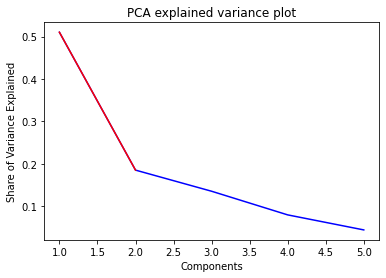

In [80]:
#plot the results
plt.plot( np.arange(1,len(pca_3.explained_variance_ratio_)+1), pca_3.explained_variance_ratio_, 'b')
plt.plot( np.arange(1,len(pca_2.explained_variance_ratio_)+1), pca_2.explained_variance_ratio_, 'r')
#add a y label
plt.ylabel('Share of Variance Explained')
plt.title("PCA explained variance plot")
plt.xlabel("Components")
#show the resuling plot
plt.show()

#### t-SNE without PCA

In [81]:
qualitative_colors = sns.color_palette("bright")
color_mapping_2 = {'Cluster 0': qualitative_colors[0], 'Cluster 1': qualitative_colors[1], 'Cluster 2': qualitative_colors[2], 'Cluster 3': qualitative_colors[3],'Cluster 4': qualitative_colors[4], 'Cluster 5': qualitative_colors[5], 'others': "grey"}

In [82]:
# Create a color mapping dictionary
color_mapping = {'Cluster 0': 'blue', 'Cluster 1': 'green', 'Cluster 2': 'purple', 'Cluster 3': 'orange','Cluster 4': 'red', 'Cluster 5': 'brown', 'others': "grey"}

/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


The df_tsne dataframe has 34411 points, whose number of non duplicate samples is 32970.

The df_tsne_filtered dataframe has 34411 points, whose number of non duplicate samples is 32948.



/opt/conda/lib/python3.9/site-packages/seaborn/relational.py:657: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = np.asarray(x), np.asarray(y), np.asarray(s), np.asarray(c)


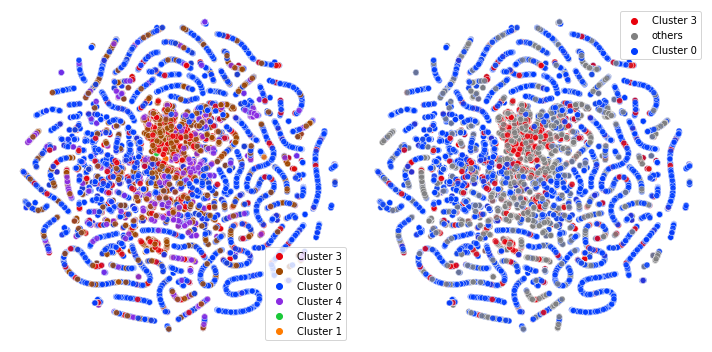

In [83]:
# with filter --> 3 colors visualization
tsne = TSNE(n_components=2, metric= "euclidean", random_state=30, perplexity=30, n_iter=1500)
tsne_projection = tsne.fit_transform(dt_frame.iloc[:, :-1])

# New DataFrame with the t-SNE components and the original cluster labels
df_tsne = pd.DataFrame({'Comp 1': tsne_projection[:, 0],
                        'Comp 2': tsne_projection[:, 1],
                        'Cluster': cluster_assignments})


# Create a color mapping dictionary
color_mapping = {'Cluster 0': 'blue', 'Cluster 1': 'green', 'Cluster 2': 'purple', 'Cluster 3': 'orange','Cluster 4': 'red', 'Cluster 5': 'brown', 'others': "grey"}
#filter
df_tsne_filtered = df_tsne.copy()
#df_tsne_filtered['Cluster'] = df_tsne_filtered['Cluster'].replace({'Cluster 0': 1, 'Cluster 1': 2, 'Cluster 2': 2, 'Cluster 3': 0, 'Cluster 4': 2, 'Cluster 5': 2})
df_tsne_filtered['Cluster'] = df_tsne_filtered['Cluster'].replace({'Cluster 0': 'Cluster 0', 'Cluster 1': 'others', 'Cluster 2': 'others', 'Cluster 3': 'Cluster 3', 'Cluster 4': 'others', 'Cluster 5':'others'})
#df_tsne_colors = df_tsne.copy()
#df_tsne_colors = df_tsne_colors['Cluster'].replace({'Cluster 0': 0, 'Cluster 1': 2, 'Cluster 2': 5, 'Cluster 3': 1, 'Cluster 4': 3, 'Cluster 5': 4})

print(f"The df_tsne dataframe has {len(df_tsne)} points, whose number of non duplicate samples is {len(df_tsne.drop_duplicates())}.\n")
print(f"The df_tsne_filtered dataframe has {len(df_tsne_filtered)} points, whose number of non duplicate samples is {len(df_tsne_filtered.drop_duplicates())}.\n")

# Plot the TSNE projection
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(10, 5))
sns.scatterplot(x='Comp 1', y='Comp 2', hue='Cluster', data=df_tsne, palette=color_mapping_2, alpha=0.8, ax = ax1)
#ax1.set_title("TSNE projection of clustered time series data without PCA")
ax1.axis('off')
ax1.legend()
sns.scatterplot(x='Comp 1', y='Comp 2', hue='Cluster', data=df_tsne_filtered, palette=color_mapping_2, alpha=0.8, ax = ax2)
#ax2.set_title("TSNE projection of clustered time series data without PCA")
ax2.axis('off')
ax2.legend()
plt.tight_layout()
plt.show()

#### t-SNE with PCA and standardized values


/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


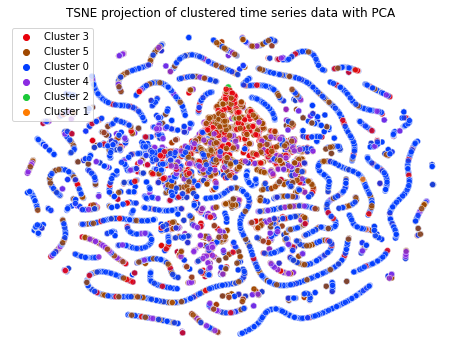

In [84]:
tsne = TSNE(n_components=2, metric= "euclidean", random_state=30, perplexity=40, n_iter=1000)
tsne_projection = tsne.fit_transform(df_pca)

# New DataFrame with the t-SNE components and the original cluster labels
df_tsne = pd.DataFrame({'Comp 1': tsne_projection[:, 0],
                        'Comp 2': tsne_projection[:, 1],
                        'Cluster': cluster_assignments})

# Plot the TSNE projection
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Comp 1', y='Comp 2', hue='Cluster', data=df_tsne, palette=color_mapping_2, alpha=0.8)
plt.title("TSNE projection of clustered time series data with PCA")
plt.axis('off')
plt.legend()
plt.show()

*Your discussion/interpretation about your model's behavior goes here*

As can be seen in the plots of the different feature baricenters, the clusters seem to assign different types of students to the different cluster.
We can additionally see that, as expected, the cluster of students that invests more time in training, generally also have a higher percentage of correct answers over their learning time.
Another noticable trend across all clusters is that between week seven and ten most students invest less time, which could either be an artefact of how we preprocess our weeks per student to not fill up weeks in which they do not have events, or it actually means that students in general loose interest in Calcularis after roughly seven weeks of continuous use.

## Task 4: Team Reflection
Please describe the contributions of each team member to Milestone 4. Reflect on how you worked as team: what went well, what can be improved for the next milestone?

*Your discussion about team responsibilities goes here*

Contributions:
- Tobias: Initial implementation of the spectral clustering with dimensionality matrices, the initial effort feature and the regularity feature. For the K-Means implementation part of the effort feature, adding weeks, the clustering pipeline using tslearn (mainly data reshaping), parameter choosing (what metric & cluster amount), running the models in full and the initial plotting of our cluster results.
- Maxime: Some additional elements of the effort feature, as well as all of the subsampling to be able to run the rest of the pipeline in a more reasonable time.
- Violeta: The implementation of the complex assessment feature currently in use as well as all of the pretty plotting for our cluster results. 

*What went well?*
The most sucessfull part for this milestone was writing the report.
That went very fast and efficiently, all members contributed different parts and flushed it out.
The discussions within the team of how we want to handle the fact that we cannot keep going with the spectral clustering went also well.

*What can be improved?*
Noone of our team managed to hit the deadlines we set ourselves.
This is also partly due to the fact that our initial implementation did end up running way too slow.
We still have to improve our time management and communication between dependencies.
One example could be working already on other extended features, even while the pipeline is not yet in working order.
